In [1]:
import importlib

from scipy.fft import rfft, rfftfreq
import numpy as np
import matplotlib.pylab as plt

from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import random

from alibi.explainers import KernelShap
import shap
shap.initjs()

from shap import Explainer
import shap.plots

/home/vnarek/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Explainability of time-series on ECG200 using Fourier Transform

In this notebook I would try to explore and reproduce results from the paper [Post Hoc Explainability for Time Series Classification: Toward a signal processing perspective](https://ieeexplore.ieee.org/document/9810094). For the dataset I have chosen [ECG200](http://timeseriesclassification.com/description.php?Dataset=ECG200).

In [2]:
def load_dataset(path):
    data = np.loadtxt(path)
    y = data[:, 0]
    data = data[:, 1:]
    return data, y

def show_sample_stats(data, y):
    tags, i = np.unique(y, return_counts=True)
    plt.pie(i, labels=tags)
    plt.show()

def process_series(data):
    yf = rfft(data, 21)
    return pd.DataFrame(np.abs(yf))
    


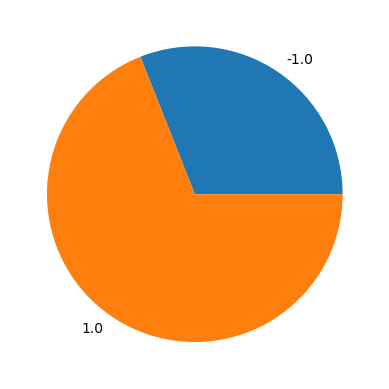

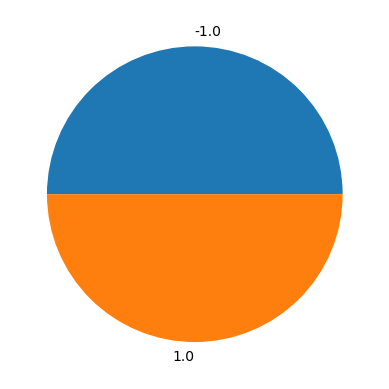

In [3]:
data, y = load_dataset("dataset_ECG200/ECG200_TRAIN.txt")

show_sample_stats(data, y)

# balance the data set using random samples from the original data
data = np.append(data, random.choices(list(data[y == -1]), k=38), axis=0)
y = np.append(y, -np.ones(38))

show_sample_stats(data, y)



In [4]:
from fft_random_forest import FFTRandomForest
from sklearn.model_selection import GridSearchCV


POINT_NUM = 21

df = process_series(data)

clf = RandomForestClassifier()
clf.fit(df, y)

gs_clf = GridSearchCV(estimator=FFTRandomForest(), n_jobs=4, param_grid={"n": list(range(10, 100))}, scoring='accuracy', cv=5)
gs_clf.fit(data, y)
gs_clf.best_params_

{'n': 71}

### Trying exponential smoothing to improve predictions

I tried smooth out the ECG, but the results were actually worse.

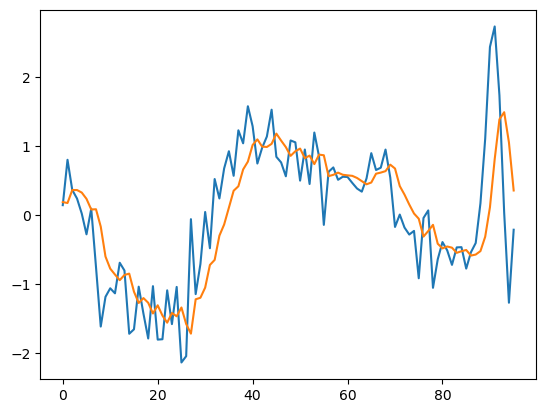

In [5]:
from statsmodels.tsa.api import SimpleExpSmoothing

fit1 = SimpleExpSmoothing(data[1]).fit(smoothing_level=0.3, optimized=True)

plt.plot(data[1])
plt.plot(fit1.fittedvalues)

### Fiting the state of the art model

I am going to compare KNN model with the classification using fourier analysis.

In [6]:
model = KNeighborsTimeSeriesClassifier(n_neighbors=3)
model.fit(data, y)
model.classes_

array([-1.,  1.])

In [7]:
test_data, y_true = load_dataset("dataset_ECG200/ECG200_TEST.txt")

df = process_series(test_data)
df.loc[0]

0      5.849120
1     12.405379
2      9.627872
3      9.350963
4      3.225795
5      2.042468
6      2.835957
7      0.569958
8      0.616083
9      1.230740
10     0.367716
Name: 0, dtype: float64

In [8]:
y_pred_proba = model.predict_proba(test_data)
y_pred = model.predict(test_data)


In [9]:

y_pred_fft = clf.predict(df)
y_pred_fft_proba = clf.predict_proba(df)

y_pred_gs_fft = gs_clf.predict(test_data)
y_pred_gs_fft_proba = gs_clf.predict_proba(test_data)

In [10]:
# KNN model
print(log_loss(y_true, y_pred_proba))
print(accuracy_score(y_true, y_pred))
print(balanced_accuracy_score(y_true, y_pred))

# FFT with random forests
print(log_loss(y_true, y_pred_fft_proba))
print(accuracy_score(y_true, y_pred_fft))
print(balanced_accuracy_score(y_true, y_pred_fft))

# FFT with random forests
print(log_loss(y_true, y_pred_gs_fft_proba))
print(accuracy_score(y_true, y_pred_gs_fft))
print(balanced_accuracy_score(y_true, y_pred_gs_fft))

2.9256738045137274
0.82
0.8168402777777778
0.33106105330052676
0.86
0.8480902777777778
0.37489749734200345
0.85
0.8159722222222222


In [11]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)

labels = km.fit_predict(data)

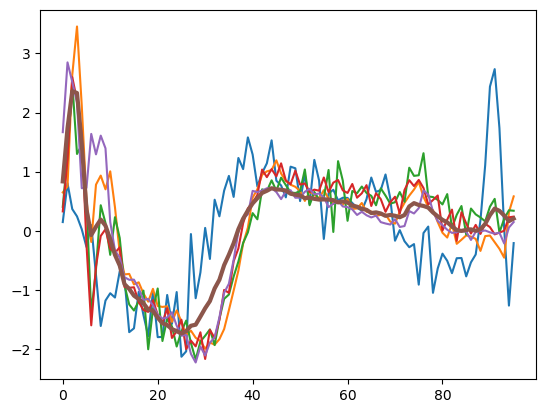

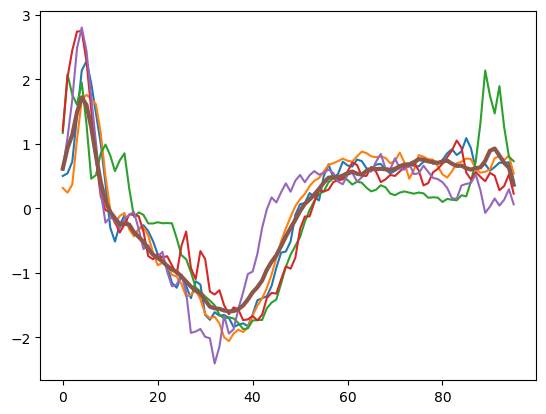

In [12]:
filtered0 = data[labels == 0]
for i in range(5):
    plt.plot(filtered0[i])
plt.plot(km.cluster_centers_[0], linewidth=3)
plt.show()
filtered1 = data[labels == 1]
for i in range(5):
    plt.plot(filtered1[i])
plt.plot(km.cluster_centers_[1], linewidth=3)
plt.show()

## Explanation using shapley values

I have chosen shapley values, which tell us how much of the resulting classification could be attributed to them. `Shap` library is really buggy, so I've used legacy version of the `waterfall` plot.

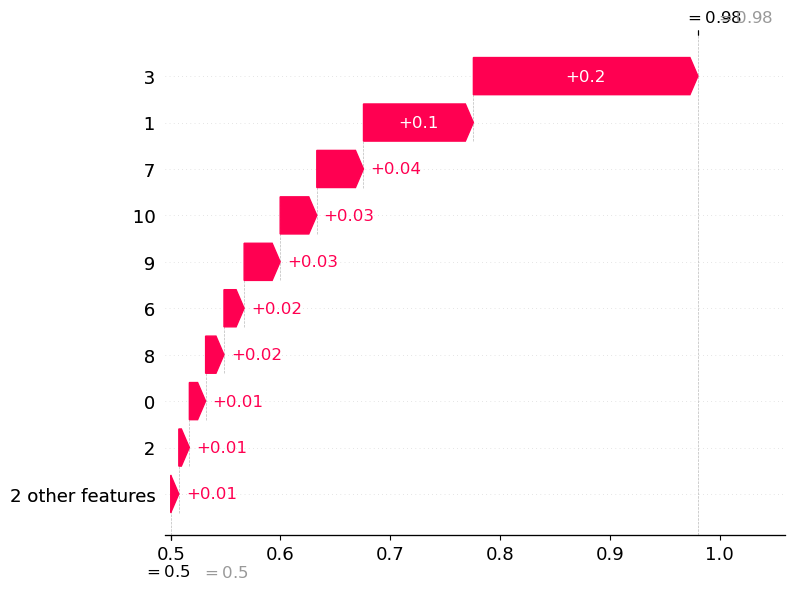

In [61]:
shape = (1,) + df.shape[1:]
explainer = shap.TreeExplainer(clf)
explanation = explainer(df.loc[3])
shap_values = explainer.shap_values(df.loc[3])
expected_value = explainer.expected_value
shap.plots._waterfall.waterfall_legacy(expected_value[0], shap_values[1], features=df.loc[1,:], feature_names=[str(x) for x in df.columns])

and here is the average impact of given feature averaged over the whole dataset

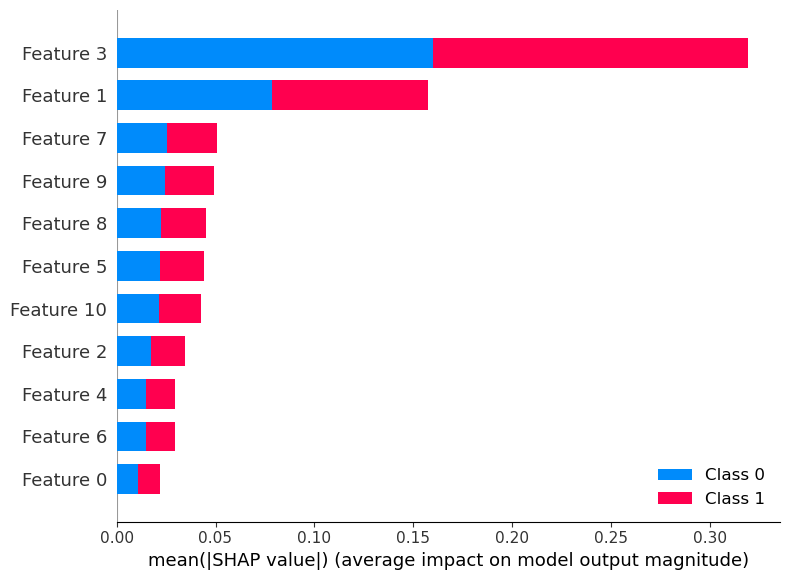

In [86]:
df.columns = [str(x) for x in df.columns]
explainer = shap.TreeExplainer(clf, df)
explanation = explainer.shap_values(df)
shap.summary_plot(explanation)